In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from fuzzywuzzy import fuzz, process
import re

In [42]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


This dataset was taken as subset of a bigger dataset (more than 4.7 million job listings) that was created by extracting data from Monster.com, a leading job board and was obtained from Kaggle.com

Link to data: https://www.kaggle.com/code/ankkur13/perfect-dataset-to-get-the-hands-dirty/notebook

In [34]:
df = pd.read_csv('jobs_data.csv')

In [35]:
df.head()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
0,United States of America,US,NaN,No,jobs.monster.com,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,Full Time Employee,"Madison, WI 53702",NaN,http://jobview.monster.com/it-support-technici...,NaN,IT/Software Development,11d599f229a80023d2f40e7c52cd941e
1,United States of America,US,NaN,No,jobs.monster.com,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,Full Time,"Madison, WI 53708",Printing and Publishing,http://jobview.monster.com/business-reporter-e...,NaN,NaN,e4cbb126dabf22159aff90223243ff2a
2,United States of America,US,NaN,No,jobs.monster.com,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,"Full Time, Employee",DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,http://jobview.monster.com/senior-training-lea...,NaN,NaN,839106b353877fa3d896ffb9c1fe01c0
3,United States of America,US,NaN,No,jobs.monster.com,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,Full Time,"Dixon, CA",Altec Industries,http://jobview.monster.com/engineer-quality-jo...,NaN,Experienced (Non-Manager),58435fcab804439efdcaa7ecca0fd783
4,United States of America,US,NaN,No,jobs.monster.com,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,Full Time Employee,"Camphill, PA",Retail,http://jobview.monster.com/shift-supervisor-pa...,NaN,Project/Program Management,64d0272dc8496abfd9523a8df63c184c


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          22000 non-null  object
 1   country_code     22000 non-null  object
 2   date_added       122 non-null    object
 3   has_expired      22000 non-null  object
 4   job_board        22000 non-null  object
 5   job_description  22000 non-null  object
 6   job_title        22000 non-null  object
 7   job_type         20372 non-null  object
 8   location         22000 non-null  object
 9   organization     15133 non-null  object
 10  page_url         22000 non-null  object
 11  salary           3446 non-null   object
 12  sector           16806 non-null  object
 13  uniq_id          22000 non-null  object
dtypes: object(14)
memory usage: 2.3+ MB


## Asssessing Level of Missing Values by Column

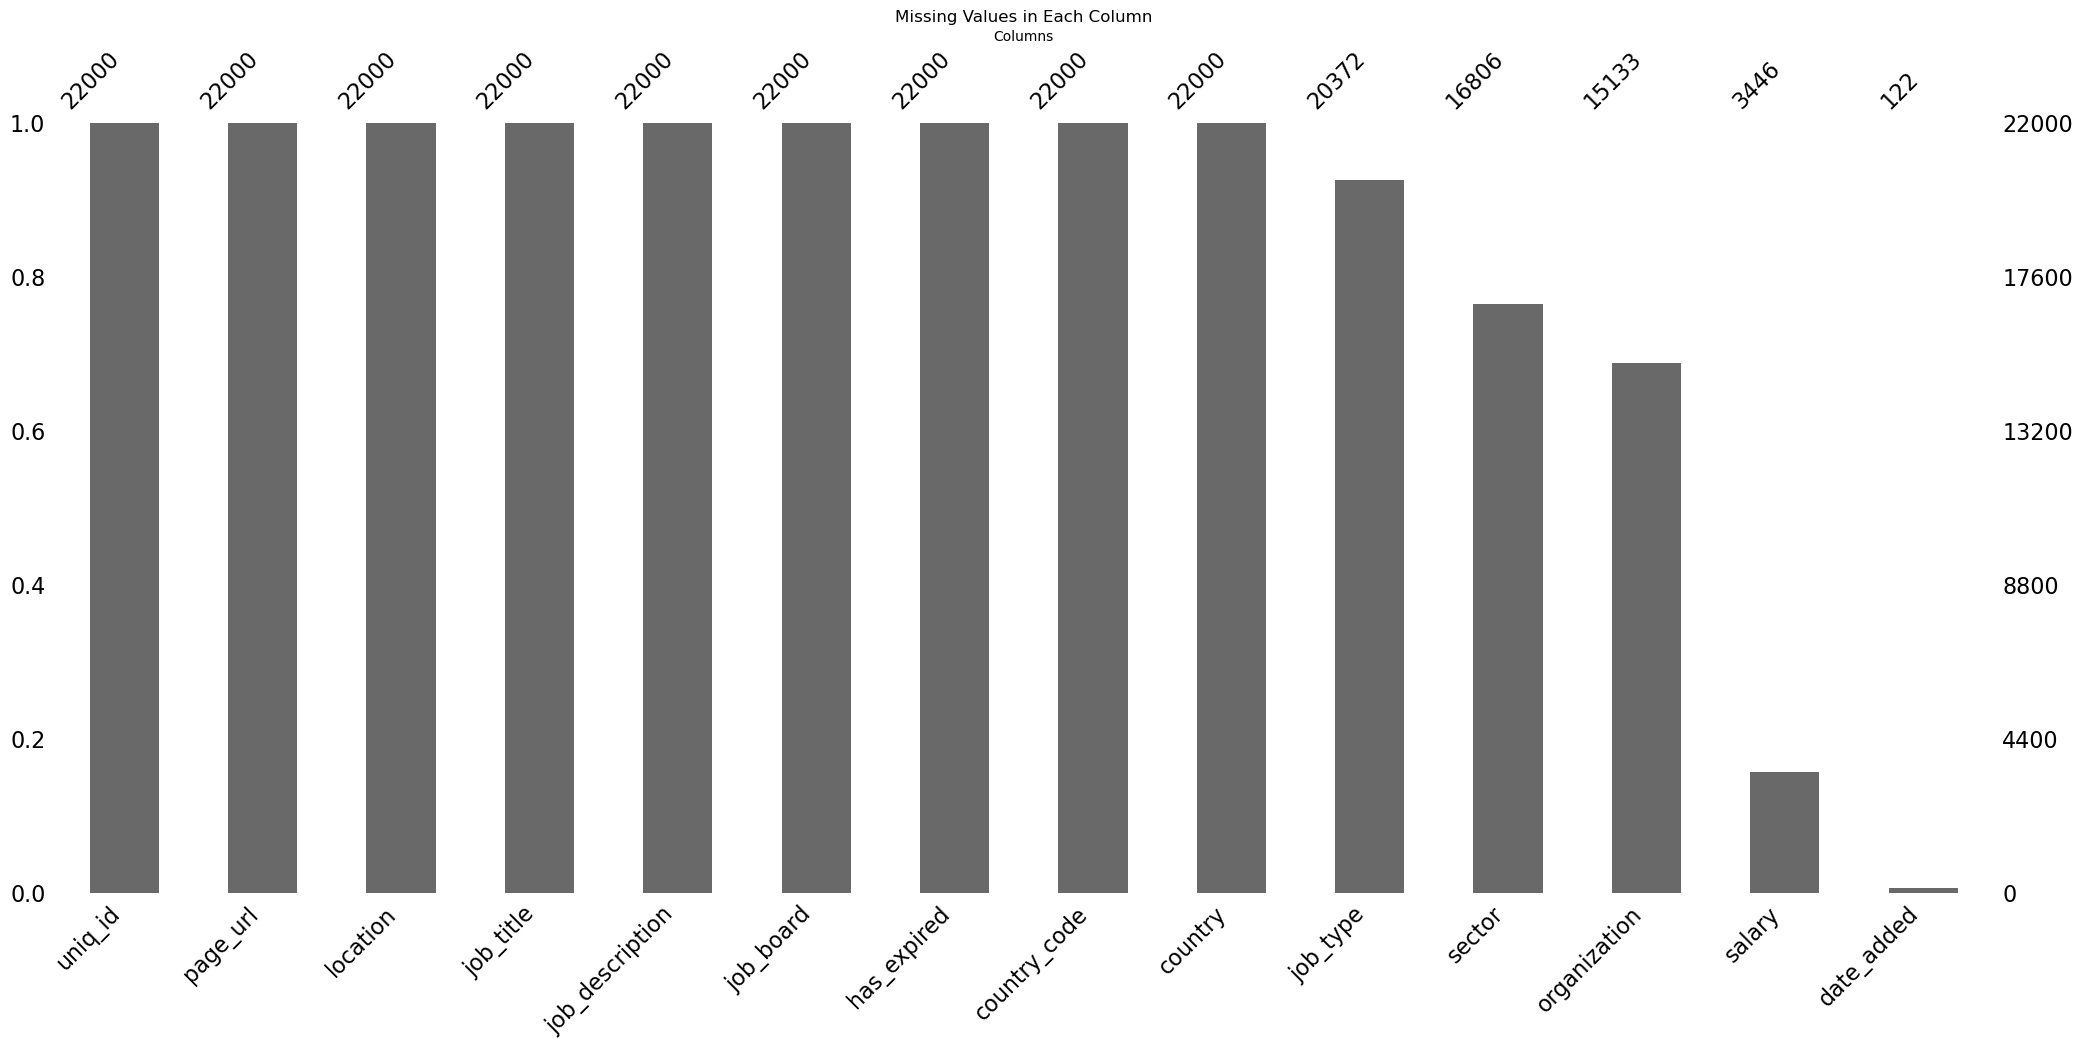

In [37]:
# Visualizing what percentage of each column has missing values
missing_plot = msno.bar(df, sort='descending')
plt.title('Missing Values in Each Column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.show()

Since 'salary' and 'date_added' both have more thant 60% missing values, those columns can be dropped

In [38]:
df.nunique()

country                1
country_code           1
date_added            78
has_expired            1
job_board              1
job_description    18744
job_title          18759
job_type              39
location            8423
organization         738
page_url           22000
salary              1737
sector               163
uniq_id            22000
dtype: int64

The columns 'country', 'country_code', 'has_expired', and 'job_board' all have the same value and therefore does not give us much useful information besides:
- All job are for positions originating in the United States of America
- Non of the job postings have expired. 
- All samples were taken from the mosters.com job board
So these columns can be dropped as well.

In [39]:
df.drop(['salary', 'date_added', 'country', 'country_code', 'has_expired', 'job_board'], axis=1, inplace=True)

## Cleaning by Column (Missing Values Fill, Answer Standardization etc)

In [40]:
df.head(2)

,job_description,job_title,job_type,location,organization,page_url,sector,uniq_id
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,Full Time Employee,"Madison, WI 53702",NaN,http://jobview.monster.com/it-support-technici...,IT/Software Development,11d599f229a80023d2f40e7c52cd941e
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,Full Time,"Madison, WI 53708",Printing and Publishing,http://jobview.monster.com/business-reporter-e...,NaN,e4cbb126dabf22159aff90223243ff2a


### Job Description

In [41]:
df['job_description']

0        TeamSoft is seeing an IT Support Specialist to...
1        The Wisconsin State Journal is seeking a flexi...
2        Report this job About the Job DePuy Synthes Co...
3        Why Join Altec? If you’re considering a career...
4        Position ID#  76162 # Positions  1 State  CT C...
                               ...                        
21995    This is a major premier Cincinnati based finan...
21996    Luxury homebuilder in Cincinnati seeking multi...
21997    RE: Adobe AEM-          Client -          Loca...
21998    Jernberg Industries was established in 1937 an...
21999    Contract AdministratorCan you be the point per...
Name: job_description, Length: 22000, dtype: object

In [43]:
# Combine all text entries for job description into a single string
combined_text = ' '.join(df['job_description'])

# Preprocess the text
combined_text = combined_text.lower()  # Convert to lowercase|
tokens = word_tokenize(combined_text)  # Tokenize the text
stopwords = set(stopwords.words("english"))  # Define the set of stopwords

# Remove stopwords and punctuation
filtered_tokens = [token for token in tokens if token.isalpha() and token not in stopwords]

# Count word frequencies
word_freq = Counter(filtered_tokens)

# Sort word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
sorted_word_freq = pd.DataFrame(sorted_word_freq)

In [48]:
sorted_word_freq.head(15)

,0,1
0,experience,45981
1,work,41046
2,skills,26571
3,ability,26179
4,job,26163
5,manager,24700
6,customer,24294
7,management,23885
8,service,23373
9,team,22336


In [52]:
df[df['job_description'].str.contains('experience')]['job_description']

0        TeamSoft is seeing an IT Support Specialist to...
1        The Wisconsin State Journal is seeking a flexi...
2        Report this job About the Job DePuy Synthes Co...
4        Position ID#  76162 # Positions  1 State  CT C...
5        Job Description Job #:  720298Apex Systems has...
                               ...                        
21994    What The Job Is AboutSales Support Representat...
21995    This is a major premier Cincinnati based finan...
21996    Luxury homebuilder in Cincinnati seeking multi...
21998    Jernberg Industries was established in 1937 an...
21999    Contract AdministratorCan you be the point per...
Name: job_description, Length: 17718, dtype: object

In [51]:
df.shape

(22000, 8)

In [65]:
def extract_context(text, keyword):
    pattern = r'(\b\w+\b\s+){0,6}' + re.escape(keyword) + r'(\s+\b\w+\b){0,6}'
    match = re.search(pattern, text)
    if match:
        return match.group(0)
    else:
        return None

In [66]:
# Example usage
long_string = "This is a long example string to demonstrate the extraction of context around a keyword."
keyword = "example"

extracted_part = extract_context(long_string, keyword)
print(extracted_part)

This is a long example string to demonstrate the extraction of


In [67]:
df['Experience'] = df['job_description'].apply(lambda x: extract_context(x, 'experience'))

### Job Title

In [76]:
df['job_title'].value_counts()

Monster                                                 318
Shift Supervisor Job in Camphill                        256
RN                                                       70
Shift Supervisor - Part-Time Job in Camphill             56
Manager                                                  50
                                                       ... 
Sales Job in Knoxville                                    1
Merchandiser Job in Madison                               1
Retail Project Merchandiser Part Time Job in Madison      1
Senior Windows Systems Administrator* Job in Madison      1
Contract Administrator Job in Cincinnati                  1
Name: job_title, Length: 18759, dtype: int64

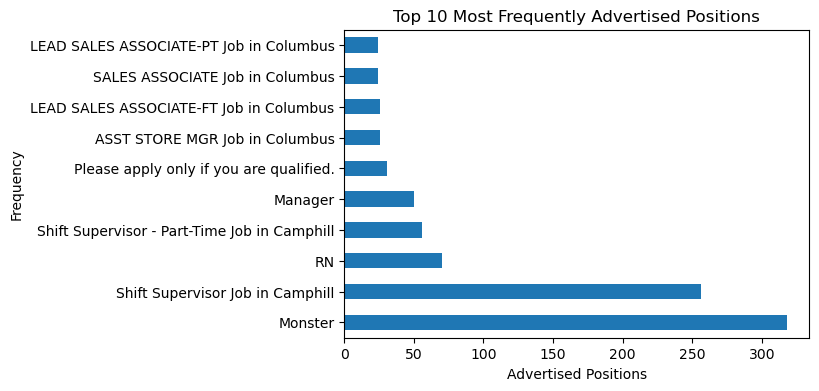

In [82]:
category_counts = df['job_title'].value_counts().head(10)
category_counts = category_counts.transpose()

plt.figure(figsize=(6, 4))
category_counts.plot(kind='barh')
plt.xlabel('Advertised Positions')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequently Advertised Positions')
plt.show()

### Job Type

In [23]:
df['job_type'].value_counts()

Full Time                                        6757
Full Time Employee                               6617
Full Time, Employee                              3360
Full Time Temporary/Contract/Project             1062
Full Time, Temporary/Contract/Project             533
Full Time , Employee                              406
Part Time Employee                                382
Part Time                                         329
Part Time, Employee                               196
Temporary/Contract/Project                        193
Employee                                          147
Full Time / Employee                              121
Full Time , Temporary/Contract/Project             56
Part Time, Temporary/Contract/Project              34
Per Diem, Employee                                 29
Per Diem                                           22
Job Type Full Time Employee                        19
Part Time Seasonal                                 17
Part Time/ Temporary/Contrac

In [9]:
def find_best_match(string, choices):
    best_match, score = process.extractOne(string, choices)
    return best_match if score >= 70 else 'Other'

In [17]:
original_column = df['job_type'].tolist()
job_types = ['Full Time', 'Part Time', 'Per Diem']
standardized_job_types = [find_best_match(str(string), job_types) for string in original_column]

In [19]:
df['job_types'] = standardized_job_types

In [21]:
df['job_types'].value_counts()

Full Time    18970
Other         1970
Part Time      993
Per Diem        67
Name: job_types, dtype: int64